In [2]:
from scipy.stats import boxcox
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_diabetes
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format

## Сырые данные по РФ


In [3]:
# Пример данных
df = pd.read_csv('regional_data/raw_Российская_Федерация.csv')
y = df["inflation"] / 100
df.drop(['inflation', 'Date'], axis=1, inplace=True)
df.head()

trade_turnover  debt_firms  money_income  paid_services  unemp  \
0   1840650960.80 18171671.00      29535.00   559456677.90   1.20   
1   1853102881.76 18184819.00      29233.00   571950883.80   1.20   
2   2032552773.82 18458002.00      31403.00   591568267.20   1.30   
3   2023565042.70 18790056.00      32949.00   599205733.80   1.20   
4   2075030365.12 19052987.00      32270.00   585407816.10   1.00   

   fm_changes_volume  fm_changes_costs  fm_changes_demand  fm_volume_exp  \
0             -33.64             16.55             -19.00          19.52   
1               0.24             19.85              -5.42          22.33   
2              10.32             21.99               0.58          21.65   
3               3.79             19.21               0.61          21.71   
4              -0.03             17.33              -1.84          20.18   

   fm_demand_exp  ...  fm_consumer_risk  fm_price_final_prod  fm_ibk  \
0          17.86  ...            -26.88                 8.88   -5.19   
1          20.61  ...            -12.19                 9.03    9.08   
2          20.25  ...             -6.89                 9.30   13.03   
3          19.75  ...             -7.26                 8.45   11.26   
4          17.87  ...             -9.34                 6.20    8.81   

   fm_econom_position  fm_econom_cond  Brent  MIACR  Infl_exp       M2  \
0               -3.66          -13.87 108.12   6.06     13.04 31155.60   
1               -3.03           -7.68 108.90   5.99     11.80 29861.20   
2               -2.56           -4.20 107.48   7.85     11.52 30169.00   
3               -1.83           -3.64 107.76   7.87     12.67 29519.30   
4               -0.94           -3.26 109.54   8.21     11.72 29879.00   

   obligates  
0       6.20  
1       6.39  
2       7.40  
3       7.50  
4       7.95  

[5 rows x 23 columns]

## Как выглядит распределение рядов без обработки


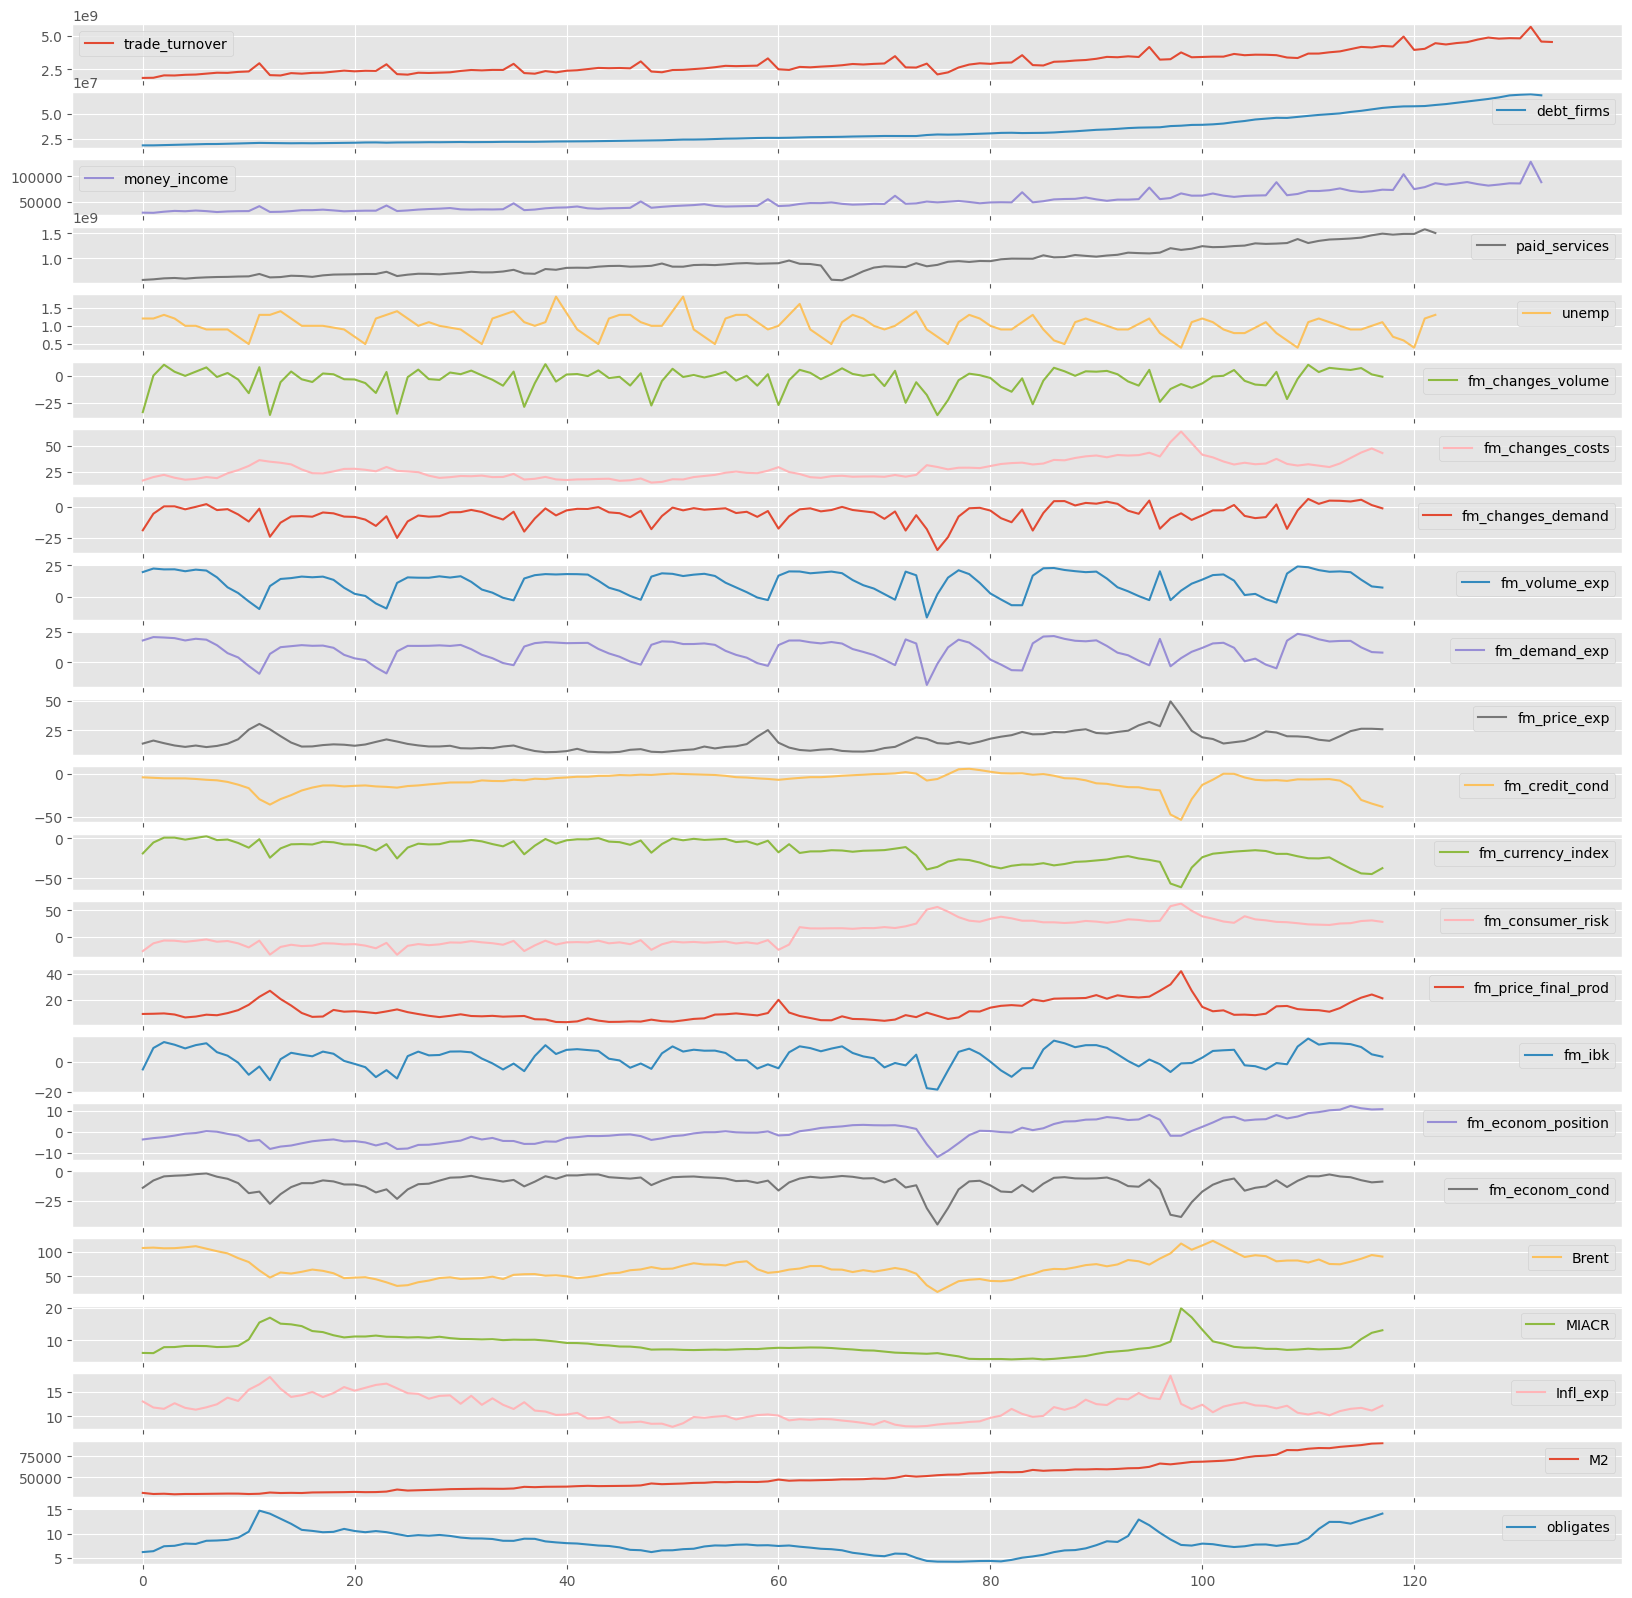

In [4]:
df.plot(kind='line', figsize=(20, 20), subplots=True);

## У денежных переменных вычищаем инфляцию


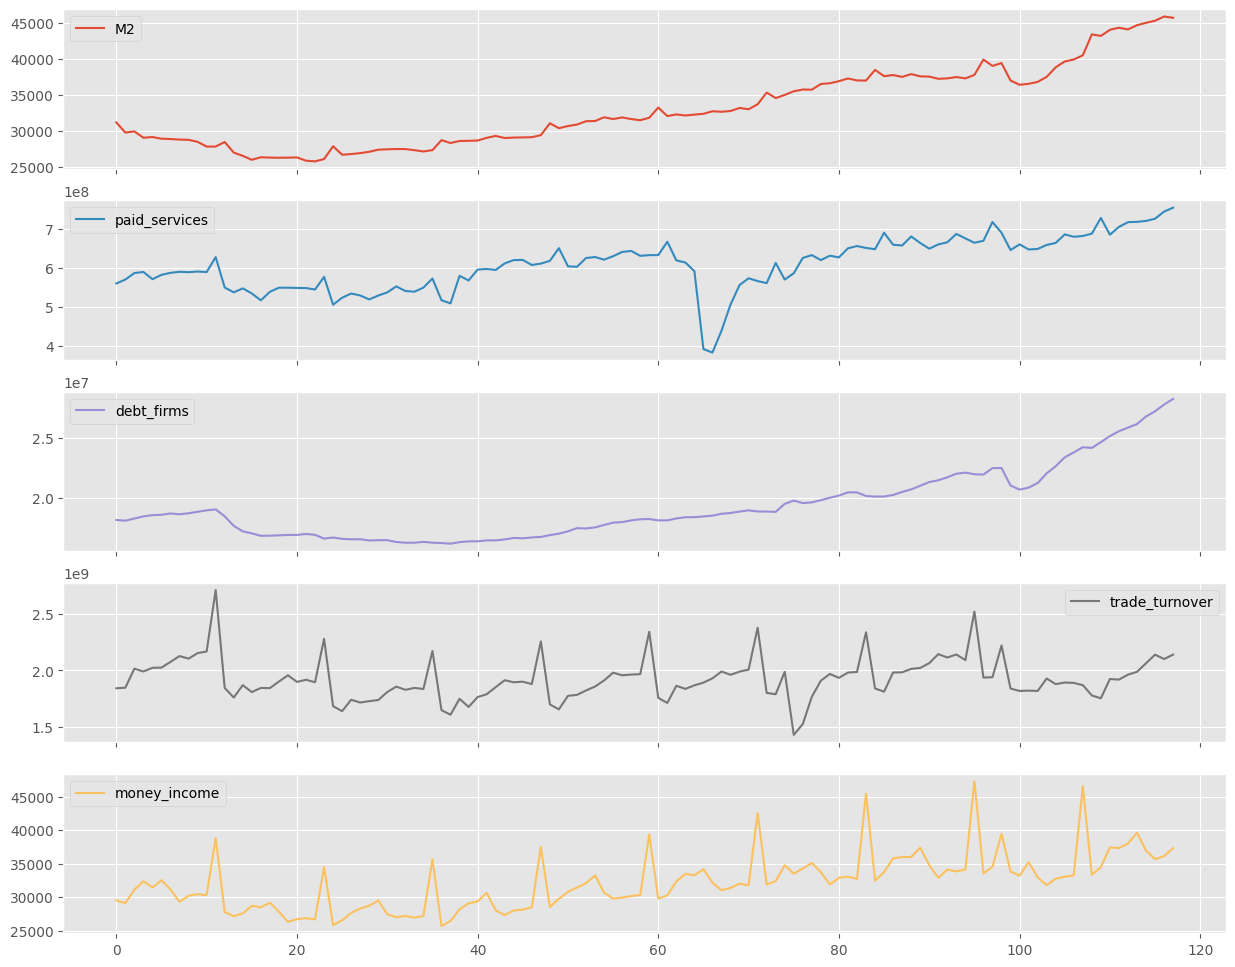

In [5]:
df_infl = df[['M2', 'paid_services', 'debt_firms',
              'trade_turnover', 'money_income']].copy()
df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover',
        'money_income'], axis=1, inplace=True)
df_infl = df_infl.dropna()
y = y.dropna()
for col in df_infl:
    for i in range(len(df_infl[col])):
        for j in range(i):
            df_infl.loc[i, col] = df_infl.loc[i, col] / y[j]
df = df.join(df_infl)
df_infl.plot(kind='line', figsize=(15, 12), subplots=True);

## Находим ряды с большой размерностью / экспоненциальным ростом и применяем логарифмирование


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

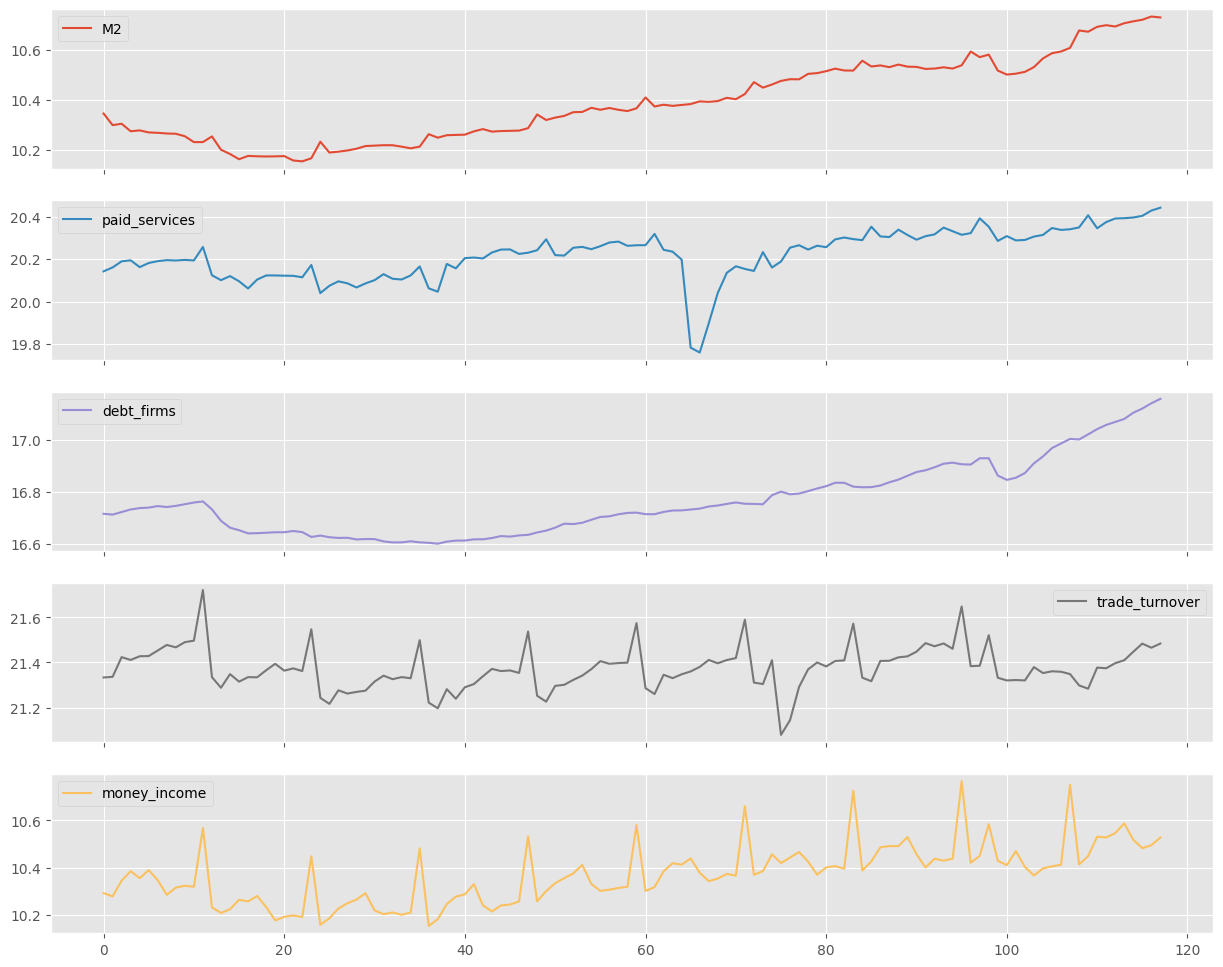

In [6]:
df_log = df[['M2', 'paid_services', 'debt_firms',
             'trade_turnover', 'money_income']].copy()
df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover',
        'money_income'], axis=1, inplace=True)
df_log = df_log.apply(lambda x: np.log(x))
df = df.join(df_log)
df_log.plot(kind='line', figsize=(15, 12), subplots=True)

## Ищем ряды с ярко выраженной годовой сезонностью и применяем сезонную корректировку


In [7]:
from statsmodels.tsa.seasonal import STL

df = df.dropna()

df_seasonal = df[['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
                  'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
                  'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms']].copy()

df.drop(['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
         'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
         'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms'], axis=1, inplace=True)
df_seasonal = df_seasonal.apply(lambda x: x - STL(x, period=12).fit().seasonal)
df = df.join(df_seasonal)

Отдельно вычищаем безработицу, так как у неё сезонность по 11 месяцев


<Axes: >

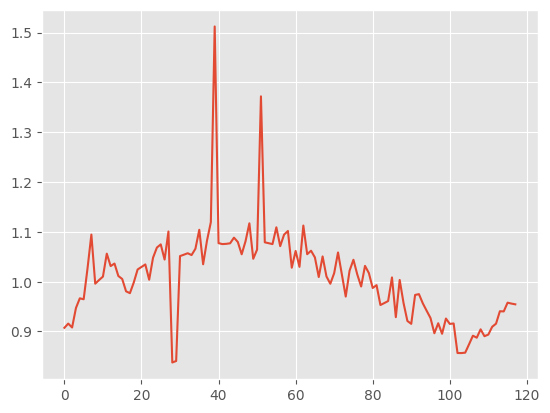

In [8]:
df['unemp'] = df['unemp'] - STL(df['unemp'], period=11).fit().seasonal
df['unemp'].plot()

## Берем первые разности и приводим ряды к 1 размерности

### Проверяем ряды на стационарность


In [9]:
# a_list = df.columns[df.apply(lambda x: adfuller(x)[1] > 0.05)].to_list()
# df.loc[:, a_list] = df.loc[:, a_list].diff(1)
df = df.diff(1)
df = df.dropna()
df.apply(lambda x: adfuller(x)[1] < 0.05)

unemp                   True
fm_changes_costs        True
fm_price_exp            True
fm_credit_cond          True
Brent                   True
MIACR                   True
Infl_exp                True
obligates               True
fm_changes_volume       True
fm_changes_demand       True
fm_volume_exp           True
fm_demand_exp           True
fm_currency_index       True
fm_consumer_risk        True
fm_price_final_prod     True
fm_ibk                  True
fm_econom_position      True
fm_econom_cond          True
M2                     False
paid_services           True
money_income            True
trade_turnover          True
debt_firms             False
dtype: bool

## Итоговое распределение рядов


## Применяем Метод главных компонент для переменных - опроссов коньюктуры рынка

### Формируем компоненты, объясняющие 90% дисперсии Х


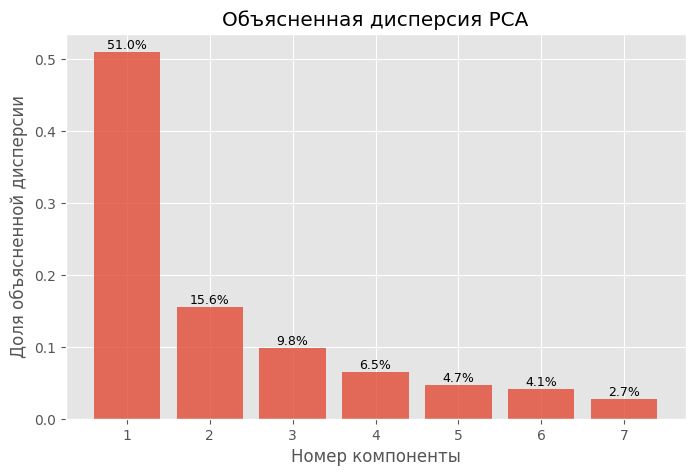

In [10]:
df = df.dropna()
X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
           'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
           'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()

X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.', 
              'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию', 
              'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']

X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                     'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                     'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_fm)

pca = PCA(n_components=0.93)
X_pca = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
loadings = pca.components_

# Визуализация объясненной дисперсии компонентами  PCA
plt.figure(figsize=(8, 5), dpi=100)
bars = plt.bar(range(1, len(explained_variance) + 1),
               explained_variance, alpha=0.8, align='center')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height*100:.1f}%',
             ha='center', va='bottom', fontsize=9)

plt.xlabel('Номер компоненты')
plt.ylabel('Доля объясненной дисперсии')
plt.xticks(np.arange(1, len(explained_variance)+1, 1))
plt.title('Объясненная дисперсия PCA')
plt.show()

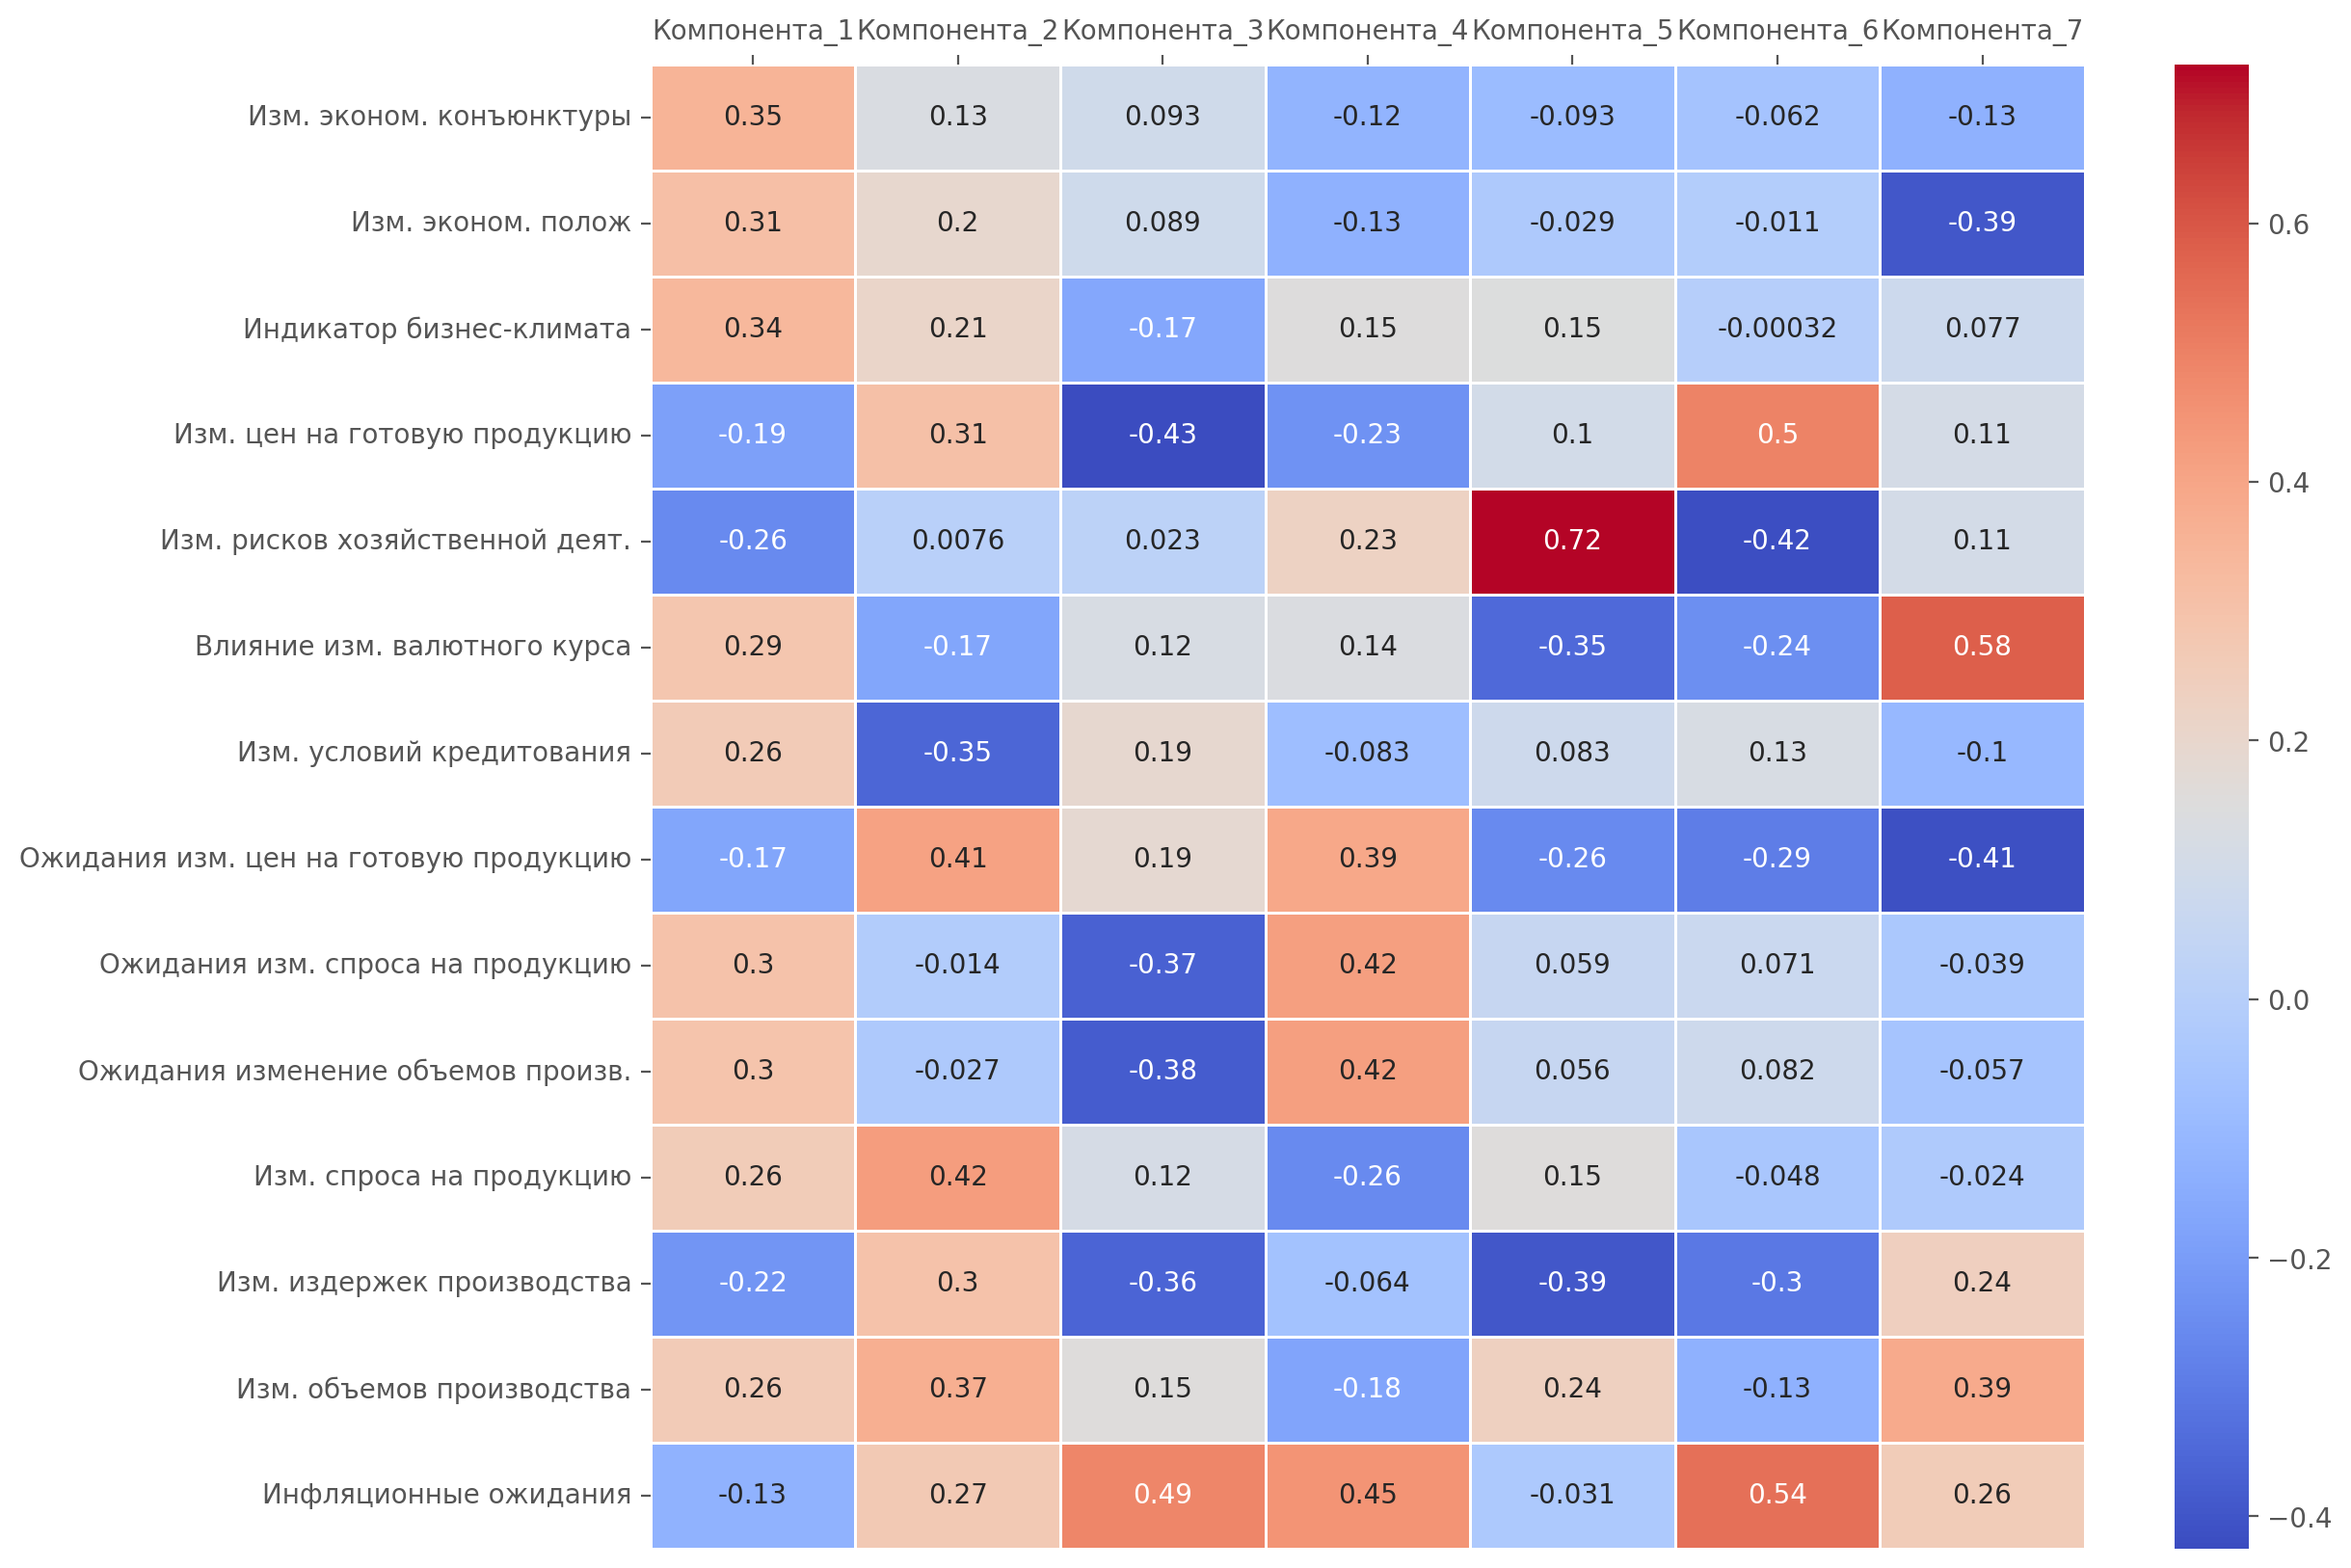

In [11]:
plt.figure(figsize=(12, 10), dpi=200)
loadings_data = pd.DataFrame(loadings, columns=X_fm.columns, index=range(1, 1+len(loadings))).T
loadings_data.columns = [f'Компонента_{i}' for i in range(1, 1+len(loadings))]
ax = sb.heatmap(loadings_data, annot=True, cmap='coolwarm', linewidth=.5);
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()

In [12]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df.columns = [f'PCA_{j+1}' for j in range(len(X_pca[0]))]
X = X.join(X_pca_df).dropna()
X

unemp  Brent  MIACR  obligates    M2  paid_services  money_income  \
1     0.01   0.78  -0.06       0.18 -0.00           0.01         -0.00   
2    -0.01  -1.42   1.85       1.02  0.00          -0.01          0.01   
3     0.04   0.28   0.03       0.10 -0.01           0.01         -0.01   
4     0.02   1.78   0.34       0.46 -0.01           0.00         -0.02   
5    -0.00   2.26   0.02      -0.07 -0.01          -0.03         -0.00   
..     ...    ...    ...        ...   ...            ...           ...   
112   0.01  -9.17   0.09       1.45  0.01          -0.00          0.02   
113   0.02  -0.63   0.08      -0.01  0.02          -0.02         -0.00   
114  -0.00   5.27   0.50      -0.35  0.01           0.01          0.01   
115   0.02   6.04   2.50       0.73  0.01           0.02          0.01   
116  -0.00   7.57   1.95       0.62  0.00           0.03         -0.00   

     trade_turnover  debt_firms  PCA_1  PCA_2  PCA_3  PCA_4  PCA_5  PCA_6  \
1              0.01        0.01  -0.65   0.11  -0.72  -0.72   0.28   0.23   
2              0.01        0.01  -0.63  -0.25   0.48  -0.05   0.49   1.53   
3              0.00        0.00  -0.13  -0.80  -0.25  -0.73  -0.02   0.20   
4             -0.01        0.00  -0.72  -0.60  -0.47   0.15  -0.76   0.19   
5             -0.00       -0.01   0.30   0.31   0.29   0.06   0.01  -0.27   
..              ...         ...    ...    ...    ...    ...    ...    ...   
112            0.02        0.02  -1.81   1.03  -0.42   0.50  -0.26   0.56   
113            0.01        0.01  -1.28   2.14  -0.66   0.27  -0.33  -0.37   
114            0.02        0.01  -2.33   1.91  -1.69   0.32  -0.49  -0.16   
115           -0.01        0.01   1.64   1.65  -1.40  -0.37  -0.95   0.02   
116            0.01        0.01   0.64   0.32   1.23   0.30   0.43   0.49   

     PCA_7  
1     0.77  
2     0.54  
3    -0.24  
4    -0.54  
5     0.84  
..     ...  
112  -0.58  
113  -0.24  
114   0.13  
115  -0.33  
116   0.38  

[116 rows x 16 columns]

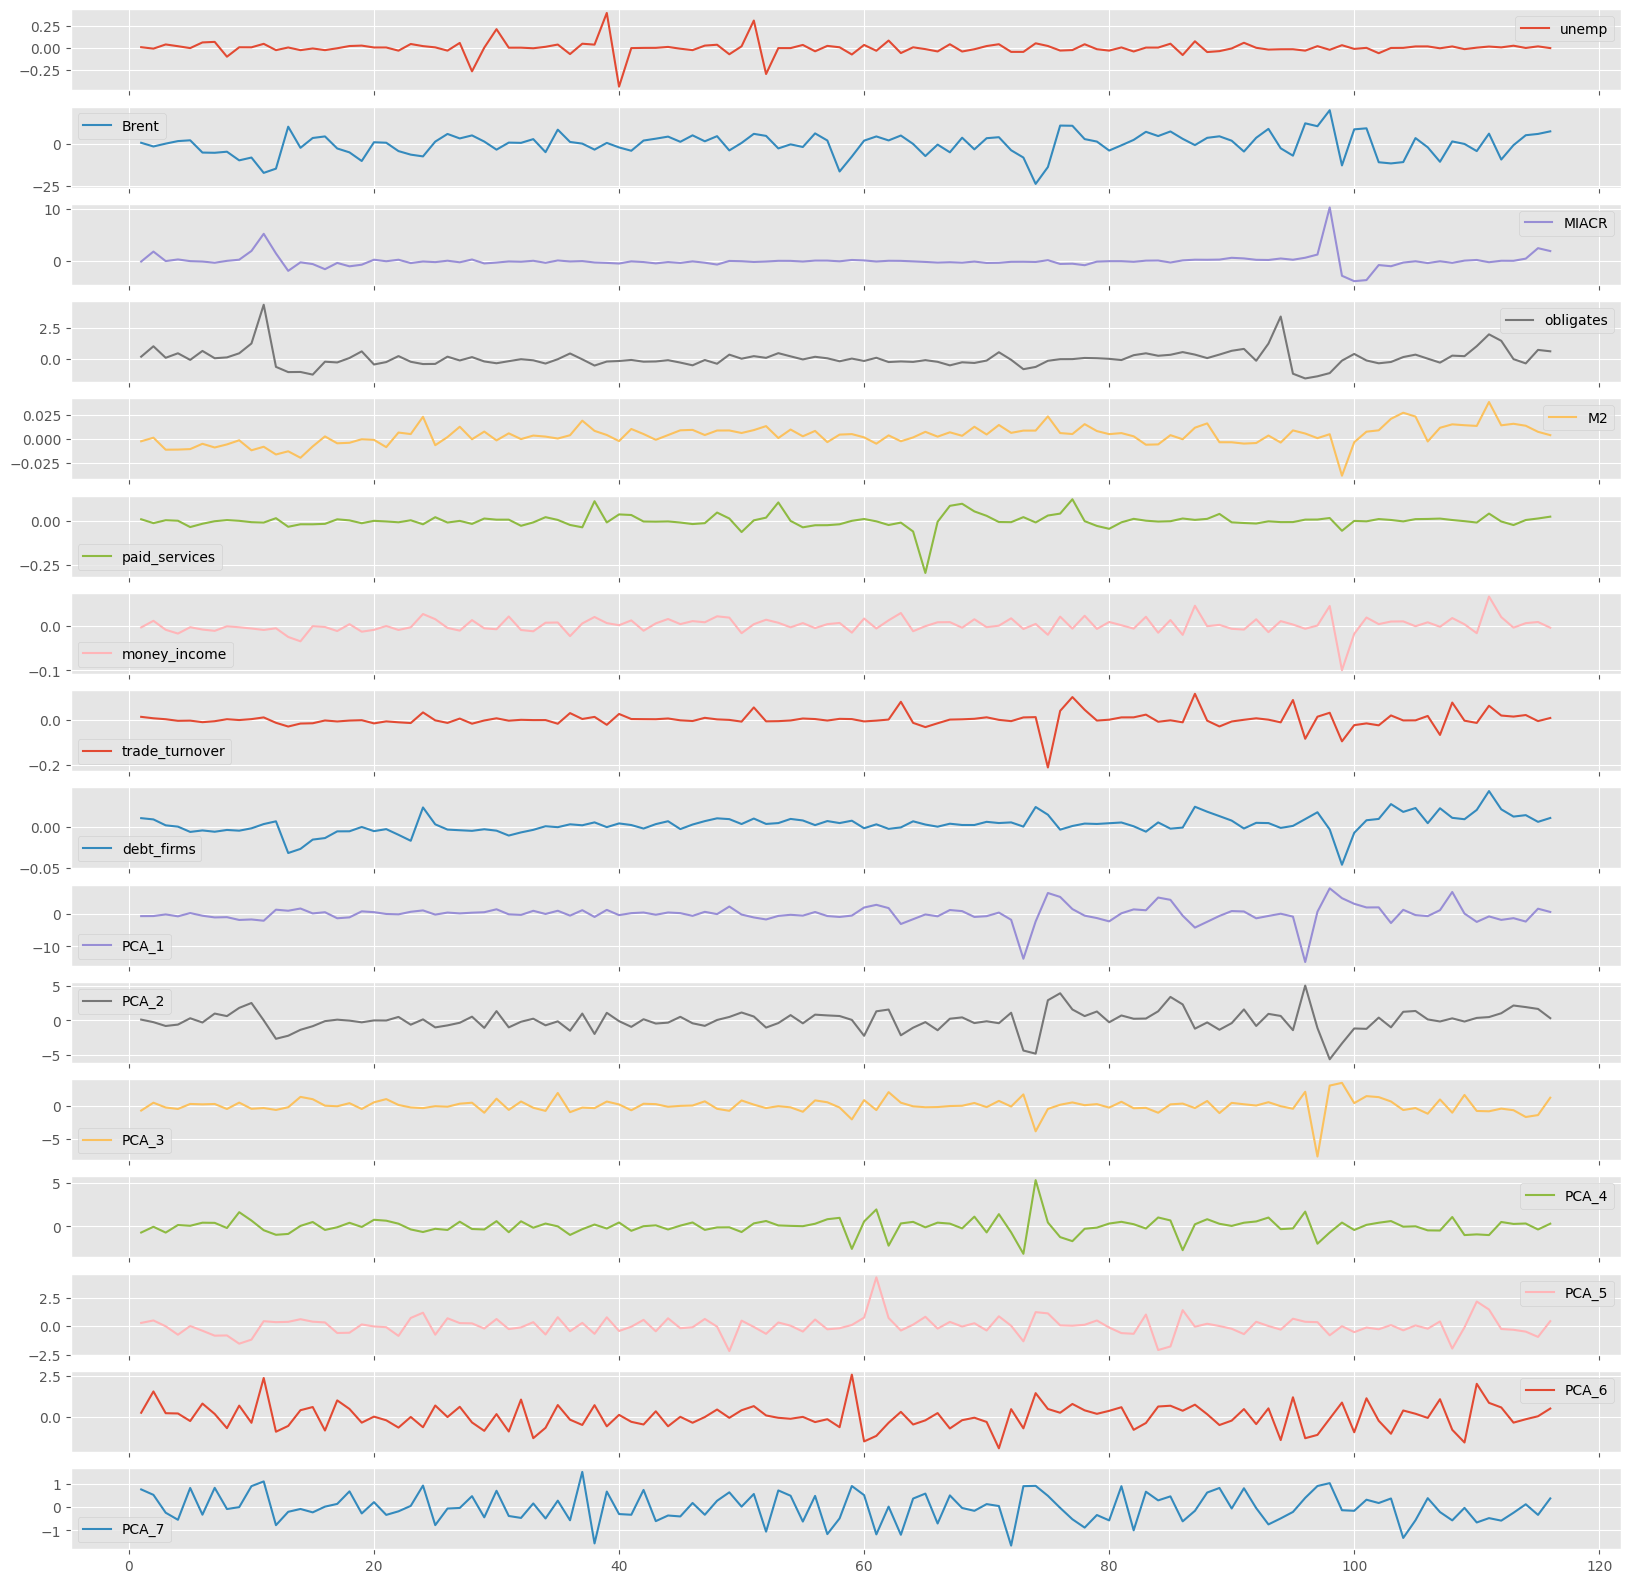

In [13]:
X.plot(subplots=True, figsize=(20, 20));

In [14]:
import os
os.makedirs('final_regional_df', exist_ok=True)
os.path.join(os.getcwd(), 'processed_regional_data')

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/processed_regional_data'

In [15]:
df = X.join(y)
df.to_csv('final_regional_df/infl_Российская_Федерация.csv', index=False)

In [16]:
plt.figure(figsize=(20, 20))
sb.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

<Axes: >

In [17]:
# Собираем списком названия файлов в папке
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
# Создаем папку, куда будем сохранять наши файлы
os.makedirs('final_regional_df', exist_ok=True)
# Создаем переменной название пути до папки с файлами (понадобится при импорте)
source_path = os.path.join(os.getcwd(), 'regional_data')


for i in range(len(file_names)):
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    # У денежных рядов делаем корректировку на инфляцию (чтобы инфляция не объясняла сама себя)
    df_infl = df[['M2', 'paid_services', 'debt_firms',
                  'trade_turnover', 'money_income']].copy()
    df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover',
            'money_income'], axis=1, inplace=True)
    df_infl = df_infl.apply(lambda x: x / (y.shift(1)))
    df = df.join(df_infl)
    # Логарифмируем ряды с большой размерностью
    df_log = df[['M2', 'paid_services', 'debt_firms',
                 'trade_turnover', 'money_income']].copy()
    df.drop(['M2', 'paid_services', 'debt_firms', 'trade_turnover',
            'money_income'], axis=1, inplace=True)
    df_log = df_log.apply(lambda x: np.log(x))
    df = df.join(df_log)
    # Делаем сезонную корректировку рядов
    df = df.dropna()
    df_seasonal = df[['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
                      'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
                      'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms']].copy()
    df.drop(['fm_changes_volume', 'fm_changes_demand', 'fm_volume_exp', 'fm_demand_exp',
             'fm_currency_index', 'fm_consumer_risk', 'fm_price_final_prod', 'fm_ibk',
             'fm_econom_position', 'fm_econom_cond', 'M2', 'paid_services', 'money_income', 'trade_turnover', 'debt_firms'], axis=1, inplace=True)
    df_seasonal = df_seasonal.apply(
        lambda x: x - STL(x, period=12).fit().seasonal)
    df = df.join(df_seasonal)
    df['unemp'] = df['unemp'] - STL(df['unemp'], period=11).fit().seasonal
    # Приводим к стационарности с помощью 1 разностей
    a_list = df.columns[df.apply(lambda x: adfuller(x)[1] > 0.05)].to_list()
    df.loc[:, a_list] = df.loc[:, a_list].diff(1)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
            'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
            'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.', 
                'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию', 
                'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                        'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                        'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])      
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=0.95)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    # Циклом проходимся по кол-ву главных компонент
    for j in range(len(X_pca[0])):
        X_pca_df = pd.DataFrame(X_pca[:, j], columns=[f'PCA_{j+1}'])
        X = X.join(X_pca_df).dropna()
    df = X.join(y)
    df.to_csv(f'final_regional_df/infl_{file_names[i][4:-4]}.csv', index=False)

## Распределение объясненной дисперсии по компонентам

In [18]:
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
rows = 39
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(160, 100), dpi=100)

for i in range(len(file_names)):
    row = i // cols
    col = i % cols
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df[['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
            'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
            'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.', 
                'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию', 
                'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                        'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                        'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])      
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    bars = axes[row, col].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align='center')
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height, f'{height*100:.1f}%', ha='center', va='bottom', fontsize=9)
    axes[row, col].set_xticks(np.arange(1, len(explained_variance)+1, 1))
    axes[row, col].set_title(f'{file_names[i][4:-4]}', fontsize=30)
plt.savefig('result/pca_region.pdf')

## Распределение переменных по компонентам

In [19]:
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/regional_data')
rows = 39
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(180, 180), dpi=100)

for i in range(len(file_names)):
    row = i // cols
    col = i % cols
    # Используем путь до папки и название региона из списка
    df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}')
    # Отделяем инфляцию и переводим ее в доли
    y = df["inflation"] / 100
    df.drop(['inflation', 'Date'], axis=1, inplace=True)
    df = df.dropna()
    # Собираем главные компоненты
    X_fm = df.loc[:,['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
            'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
            'fm_changes_costs', 'fm_changes_volume', 'Infl_exp']].copy()
    X_fm.columns = ['Изм. эконом. конъюнктуры', 'Изм. эконом. полож', 'Индикатор бизнес-климата', 'Изм. цен на готовую продукцию', 'Изм. рисков хозяйственной деят.', 
                'Влияние изм. валютного курса', 'Изм. условий кредитования', 'Ожидания изм. цен на готовую продукцию', 'Ожидания изм. спроса на продукцию', 
                'Ожидания изменение объемов произв.', 'Изм. спроса на продукцию', 'Изм. издержек производства', 'Изм. объемов производства', 'Инфляционные ожидания']
    X = df.drop(columns=['fm_econom_cond', 'fm_econom_position', 'fm_ibk', 'fm_price_final_prod', 'fm_consumer_risk', 'fm_currency_index',
                        'fm_credit_cond', 'fm_price_exp', 'fm_demand_exp', 'fm_volume_exp', 'fm_changes_demand',
                        'fm_changes_costs', 'fm_changes_volume', 'Infl_exp'])
    # Стандартизация данных, так как это чувствительная вещь
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fm)
    pca = PCA(n_components=0.9)
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = pca.explained_variance_ratio_
    loadings = pca.components_
    loadings_data = pd.DataFrame(loadings, columns=X_fm.columns, index=range(1, 1+len(explained_variance))).T
    sb.heatmap(loadings_data, annot=True, cmap='coolwarm', linewidth=.5 ,ax=axes[row, col])
    plt.title(f'Состав компонент {file_names[0][4:-4]}')
plt.tight_layout()  # улучшает расположение подграфиков

# Попробуйте сначала PNG
plt.savefig('result/fm_in_pca.png', bbox_inches='tight')
plt.close()